In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pmdarima
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.1 MB/s eta 0:00:00


In [ ]:
def first_prep(data_path):
  data=pd.read_csv(data_path)
  data["Time(year-month-day h:m:s)"] = pd.to_datetime(data["Time(year-month-day h:m:s)"])
  data= data.sort_values(by='Time(year-month-day h:m:s)', ascending=True)
  data.set_index('Time(year-month-day h:m:s)', inplace=True)
  data=data.resample('H').mean()
  return data

In [ ]:
solar_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Solar-station-site-1-_Nominal-capacity-50MW_.csv')
wind_data=first_prep('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/Wind-farm-site-1-_Nominal-capacity-99MW_-_1_.csv')

In [ ]:
#split data to feautres and label
def split_features_label(data,label=''):
  label=data[[label]].copy()
  features=data.drop(label,axis=1)
  return features,label

In [ ]:
features_S,label_S=split_features_label(solar_data,label='Power (MW)')
features_W,label_W=split_features_label(wind_data,label='Power (MW)')

In [ ]:
#split to train and test
#Split the data into train and test for solar data
train_S_f=features_S[:int(len(solar_data)*0.8)]
train_S_l=label_S[:int(len(solar_data)*0.8)]
test_S_f=features_S[int(len(solar_data)*0.8):]
test_S_l=label_S[int(len(solar_data)*0.8):]
#Split the data into train and test for wind data
train_W_f=features_W[:int(len(wind_data)*0.8)]
train_W_l=label_W[:int(len(wind_data)*0.8)]
test_W_f=features_W[int(len(wind_data)*0.8):]
test_W_l=label_W[int(len(wind_data)*0.8):]

In [ ]:
def evalute_model(model,data,train,test_f,test_l,start,step_in,n_forecast,color_d):
 forecast = model.get_forecast(steps=n_forecast+1, exog=test_f[step_in:step_in+n_forecast+1])

 plt.figure(figsize=(10,5))
 plt.plot(data.index[len(train)+start:len(train)+step_in+1+start],data[len(train)+start:len(train)+step_in+1+start],label='12 heures avant',color=color_d)
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],test_l[step_in+start:step_in+n_forecast+1+start],label='6 heures après',color='green')
 plt.plot(data.index[len(train)+step_in+start:len(train)+step_in+n_forecast+1+start],forecast.predicted_mean,linestyle='dashed',color='red',label='Prévision par SARIMAX')
 plt.xlabel('Temps')
 plt.ylabel('Energie en (MW)')
 plt.legend()
 plt.title('Valeurs prévisionnelles vs Valeurs réelles')
 mae=mean_absolute_error(test_l[:n_forecast+1],forecast.predicted_mean)
 mse=mean_squared_error(test_l[:n_forecast+1],forecast.predicted_mean)
 rmse = np.sqrt(mse)
 mape = mean_absolute_percentage_error(test_l[:n_forecast+1],forecast.predicted_mean)
 print('mae=',mae)
 print('mse=',mse)
 print('rmse=',rmse)
 print('mape=',mape)
 return forecast.predicted_mean

In [ ]:
train_S_f.shape

(14035, 6)

In [ ]:
#solar sarimax model
model_SARIMAX_S = SARIMAX(train_S_l, exog=train_S_f, order= (24, 1, 1)).fit()

In [ ]:
import pickle
def save_model(model,file_name):
 # Save the trained ARMA model using pickle
 with open(file_name, 'wb') as file:
    pickle.dump(model, file)

def load_model(file_name):
  with open(file_name, 'rb') as file:
    loaded_model = pickle.load(file)
  return loaded_model

In [ ]:
save_model(model_SARIMAX_S,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMAX_S.pkl')

In [ ]:
model_SARIMAX_S=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMAX_S.pkl')

mae= 6.1566974318996674
mse= 61.624772744812645
rmse= 7.850144759481359
mape= 9854209613004414.0


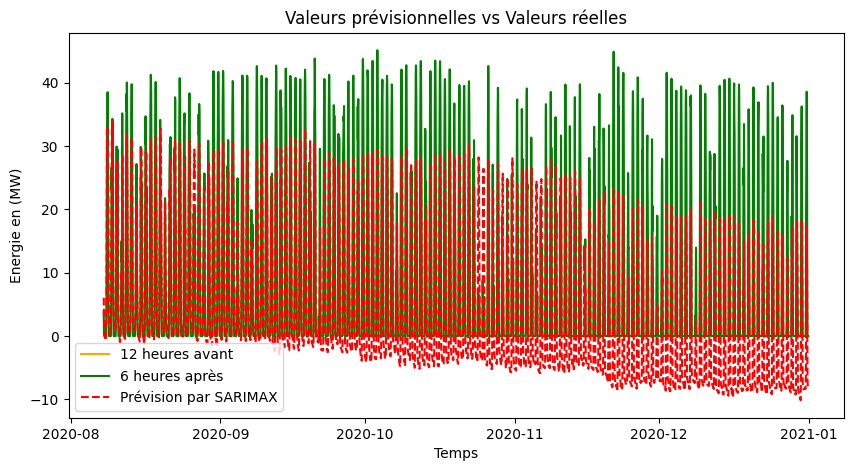

In [ ]:
prediction_SARIMAX_S=evalute_model(model_SARIMAX_S,solar_data['Power (MW)'],train_S_f,test_S_f,test_S_l,0,0,len(test_S_l)-2,'orange')

In [ ]:
#wind SARIMAX model
model_SARIMAX_W = SARIMAX(train_W_l, exog=train_W_f, order= (24, 1, 1)).fit()

In [ ]:
save_model(model_SARIMAX_W,'/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMAX_W.pkl')

In [ ]:
model_SARIMAX_W=load_model('/content/drive/MyDrive/PV_Wind_Power_Forecasting_Hmidani_Hicham/model_SARIMAX_W.pkl')

mae= 25.616743168332782
mse= 772.7532686319009
rmse= 27.798440039540004
mape= 24.970826040870026


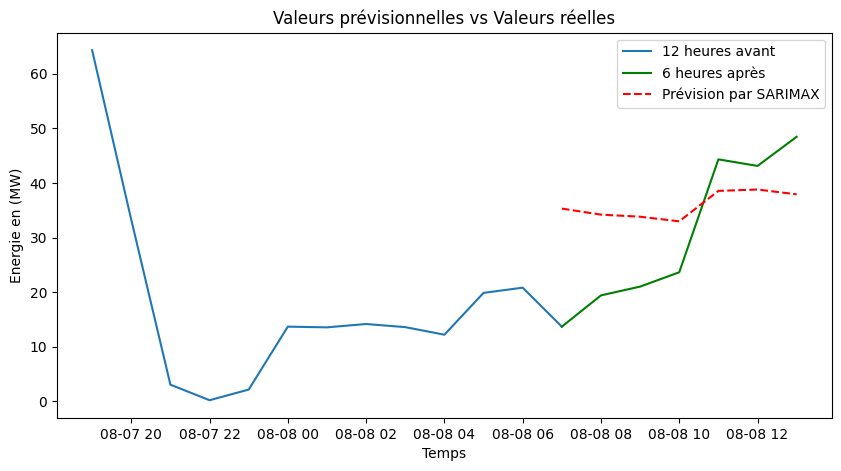

In [ ]:
prediction_SARIMAX_W=evalute_model(model_SARIMAX_W,wind_data['Power (MW)'],train_W_f,test_W_f,test_W_l,0,12,6,None)